## Import necessary modules

In [1]:
import os
import json
import math

# ! pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sn

from tqdm import tqdm

from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.transforms.functional import pad
from torch.utils.data import DataLoader, SubsetRandomSampler

## Data loader with Preprocessing

In [ ]:
dataset_path = "data/all_preprocessed_data/"

# Transforms pipeline for train and validation data loaders
preprocess = transforms.Compose([
    transforms.Resize([100, ]),
    transforms.Lambda(
        lambda img: pad(img, padding=(0, 0, max(0, 200 - img.width), max(0, 100 - img.height)), 
                                              fill=(255, 255, 255))),
    transforms.CenterCrop((100, 200)),
#   thinning

#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load the entire dataset (since we don't have a train and validation split in the )
dataset = ImageFolder(dataset_path, transform=preprocess)

## Split dataset into Training and Validation sets

In [ ]:
! ls data/all_data/handwritten | wc -l
! ls data/all_preprocessed_data/handwritten | wc -l

In [ ]:
! ls data/all_data/typed | wc -l
! ls data/all_preprocessed_data/typed | wc -l

In [ ]:
# Define the percentage of samples for the validation set
val_split = 0.2  # 10% for validation

# Calculate the sizes of the train and validation sets
val_size = int(val_split * len(dataset))
train_size = len(dataset) - val_size

print("Total number of images: ", len(dataset), 
      "\nTraining images: ", train_size, "\nValidation images: ", val_size)

# Create indices for train and validation sets
indices = list(range(len(dataset)))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create subset samplers for train and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

batch_size = 32

# Create data loaders for train and validation sets
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

In [ ]:
# Iterate over the data loader to get a batch of transformed images
for images, labels in train_loader:
    # Convert images to numpy array and transpose dimensions from (batch_size, channels, height, width)
    # to (batch_size, height, width, channels)
    images = images.numpy().transpose(0, 2, 3, 1)

    # Plot the images
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i in range(4):
        axes[i].imshow(images[i])
#         axes[i].imshow((images[i] * 255).astype(np.uint8))
        axes[i].axis('off')
    plt.show()
    break  # Only display one batch of transformed images

In [ ]:
# Move the model to the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

## Training and Validation loop

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(101)

# Define the number of classes in your specific task
num_classes = 2

# ======================================================================== #

# # Load the pre-trained ResNet model
# model = models.resnet50(weights=True)

# # Modify the first convolutional layer to accept grayscale images
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# # Modify the last fully connected layer to match the number of classes
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, num_classes-1)



# # Load the pre-trained VGG16 model
# model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")

# # Modify the first convolutional layer to accept grayscale images
# model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# # Modify the last fully connected layer to match the number of classes in your task
# num_features = model.classifier[6].in_features
# model.classifier[6] = torch.nn.Linear(num_features, num_classes-1)



# # Load pretrained MobileNetV2 model and reset final fully connected layer.
# model = models.mobilenet_v2(pretrained=True)
# model.classifier[1] = nn.Linear(model.last_channel, num_classes-1)



# Load pre-trained DenseNet model
model = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")

# Replace the last layer for binary classification
model.classifier = nn.Linear(model.classifier.in_features, num_classes-1)

# ======================================================================== #


# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
# optimizer = optim.SGD(model.classifier[1].parameters(), lr=0.001, momentum=0.9) -> for MobileNetV2
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)

# Training loop
num_epochs = 50

patience = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    
    with tqdm(enumerate(train_loader), total=math.ceil(train_size/batch_size)) as pbar:

#         train_pred = []
#         train_true = []
        
        for batch_idx, (images, labels) in pbar:

            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to 0 or 1
            train_correct += (predicted == labels).sum().item()
            
#             train_true.extend(labels) # Save Truth
#             train_pred.extend(predicted) # Save Prediction

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0

        y_pred = []
        y_true = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(images)

                loss = criterion(outputs, labels)

                val_loss += loss.item()

                predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to 0 or 1
                val_correct += (predicted == labels).sum().item()
                
#                 y_true.extend(labels) # Save Truth
#                 y_pred.extend(predicted) # Save Prediction

                
        # Calculate average loss and accuracy
        train_loss /= train_size
        train_accuracy = train_correct / train_size

        val_loss /= val_size
        val_accuracy = val_correct / val_size
        
        # Compute F1-scores after moving tensors to CPU
#         train_true_cpu = [tensor.cpu().detach().numpy() for tensor in train_true]
#         train_pred_cpu = [tensor.cpu().detach().numpy() for tensor in train_pred]
        
#         y_true_cpu = [tensor.cpu().detach().numpy() for tensor in y_true]
#         y_pred_cpu = [tensor.cpu().detach().numpy() for tensor in y_pred]
        
#         train_f1 = f1_score(train_true_cpu, train_pred_cpu)
#         val_f1 = f1_score(y_true_cpu, y_pred_cpu)

#         print(f'Epoch [{epoch + 1}/{num_epochs}], \n'
#         f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1-score: {train_f1:.4f}, \n'
#         f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1-score: {val_f1:.4f} \n'
#         )
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], \n'
        f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, \n'
        f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f} \n'
        )

        # Save the best model based on validation loss and early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # Save the model
            print("Saving model...")
            torch.save(model.state_dict(), 'model/densenet_not_best_model.pth')
        else:
            counter += 1
            # Check if the counter reaches the patience limit
            if counter >= patience:
                print('Early stopping triggered...')
            break

print("\n=== Training complete! ===\n")

In [268]:
# torch.save(model.state_dict(), 'model/densenet_best_model.pth')

## Testing loop

### A small number of images have been manually segregated into handwritten and machine printed text to test the model's performance.

In [4]:
# Load the best model
# best_model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")

# # Modify the first convolutional layer to accept grayscale images
# best_model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# # Modify the last fully connected layer to match the number of classes in your task
# num_features = best_model.classifier[6].in_features
# best_model.classifier[6] = torch.nn.Linear(num_features, 1)


best_model = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
# Modify the model for binary classification
num_ftrs = best_model.classifier.in_features
best_model.classifier = nn.Linear(num_ftrs, 1)

best_model.load_state_dict(torch.load('model/densenet_not_best_model.pth')) # vgg16_best_model
best_model = best_model.to(device)

In [5]:
# 
test_preprocess = transforms.Compose([
    transforms.Resize([100, ]),
    transforms.CenterCrop((100, 200)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(degrees=90),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [6]:
# Evaluate the best model on the test dataset
test_dataset = ImageFolder("data/test_data/", transform=test_preprocess)
test_loader = DataLoader(test_dataset, batch_size=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 3, 100, 200)
(16, 100, 200, 3)


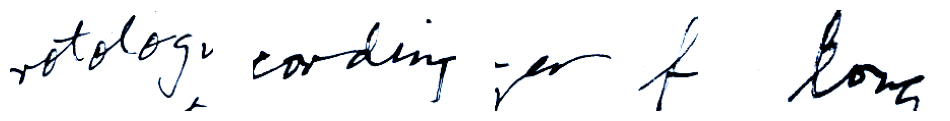

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 3, 100, 200)
(10, 100, 200, 3)


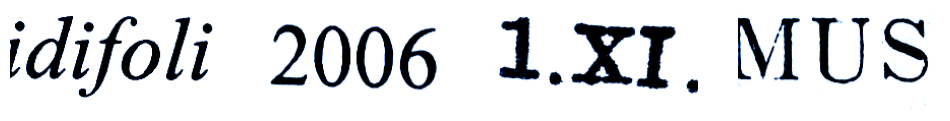

In [7]:
# Iterate over the data loader to get a batch of transformed images
for images, labels in test_loader:
    print(images.numpy().shape)
    # Convert images to numpy array and transpose dimensions from 
    # (batch_size, channels, height, width) to (batch_size, height, width, channels)
    images = images.numpy().transpose(0, 2, 3, 1)
    
    print(images.shape)

    # Plot the images
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i in range(4):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

In [8]:
best_model.eval()
y_pred = []
y_true = []

test_loss = 0
test_correct = 0

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = best_model(images)

        loss = criterion(outputs, labels)

        test_loss += loss.item()

        predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to 0 or 1
        test_correct += (predicted == labels).sum().item()

        y_true.extend(labels) # Save Truth
        y_pred.extend(predicted) # Save Prediction


# Compute F1-scores
y_true_cpu = [tensor.cpu().detach().numpy() for tensor in y_true]
y_pred_cpu = [tensor.cpu().detach().numpy() for tensor in y_pred]

In [9]:
test_f1 = f1_score(y_true_cpu, y_pred_cpu)
test_f1

0.7333333333333334

In [10]:
test_correct/len(test_loader.dataset)

0.6923076923076923

In [13]:
# y_true_cpu, y_pred_cpu

(16, 3, 100, 200)
(16, 100, 200, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

IndexError: index 16 is out of bounds for axis 0 with size 16

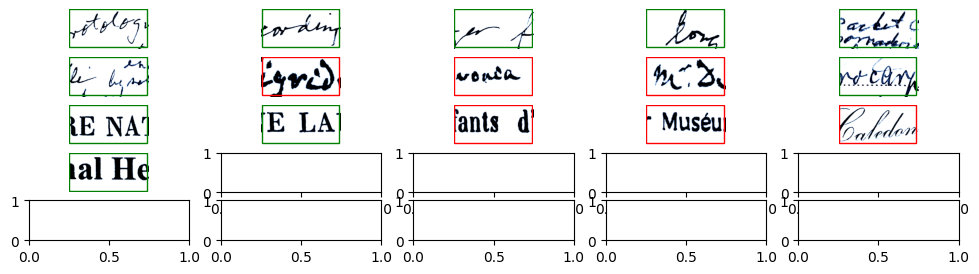

In [11]:
img_no = 0

# Iterate over the data loader to get a batch of transformed images
for images, labels in test_loader:
    print(images.numpy().shape)
    # Convert images to numpy array and transpose dimensions from 
    # (batch_size, channels, height, width) to (batch_size, height, width, channels)
    images = images.numpy().transpose(0, 2, 3, 1)
    
    print(images.shape)
    
    num_rows = 5

    # Plot the images
    fig, axes = plt.subplots(num_rows, int(len(test_loader.dataset)/num_rows), figsize=(12, 3))
    for i in range(num_rows):
        for j in range(int(len(test_loader.dataset)/num_rows)):
            axes[i][j].imshow(images[img_no%len(test_loader.dataset)])
            axes[i][j].axis('off')
            
            edge_color = 'g'
            if(y_true_cpu[img_no] != y_pred_cpu[img_no]):
                edge_color = 'r'
            
            
            # Create a Rectangle patch
            rect = patches.Rectangle((0, 0), 195, 95, linewidth=1, edgecolor=edge_color, facecolor='none')
            axes[i][j].add_patch(rect)
            img_no += 1
    plt.show()

In [ ]:
#  Image 8 misclassified most probably due to COCO-Text